In [2]:
# -*- coding: utf-8 -*-

In [14]:
import re
import os
import sys
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import json
from scipy import stats
import csv
import pprint
from collections import defaultdict
import time
import datetime
import math
# import matplotlib.pyplot as plt; plt.rcdefaults()
# from IPython.display import Markdown, display

In [3]:
TIME_CHUNK_IN_DAYS = 10
QUARANTINE_DATE = "28/09/2018"
quarDataUnix = time.mktime(datetime.datetime.strptime(QUARANTINE_DATE, "%d/%m/%Y").timetuple())

def getTimeChunkIndex(timeStamp):
    timeStamp = float(timeStamp)
    timeDiff = timeStamp - quarDataUnix
    timeDiffDays = float(timeDiff)/(24*60*60) 
    chunkIndex = math.floor(timeDiffDays/TIME_CHUNK_IN_DAYS)
    return int(chunkIndex)

/nethome/eshwar3/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [63]:
data = pd.read_csv("/mnt/storage/quarantine/data/theRedPillComments-toxicity.csv")
data['post_treatment'] = data['created_utc'] > quarDataUnix
data['time'] = data['created_utc'].apply(getTimeChunkIndex)
data = data[data.toxicity != -1]

/nethome/eshwar3/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# ITS for Toxicity scores

In [64]:
model = smf.ols('toxicity ~ time + post_treatment',data = data)
results = model.fit()

In [65]:
print(results.summary2())

                    Results: Ordinary least squares
Model:                OLS               Adj. R-squared:      0.000     
Dependent Variable:   toxicity          AIC:                 78508.5862
Date:                 2019-07-11 18:25  BIC:                 78539.1138
No. Observations:     194049            Log-Likelihood:      -39251.   
Df Model:             2                 F-statistic:         14.18     
Df Residuals:         194046            Prob (F-statistic):  6.92e-07  
R-squared:            0.000             Scale:               0.087746  
-----------------------------------------------------------------------
                        Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               0.3714   0.0015 243.5655 0.0000  0.3684  0.3744
post_treatment[T.True] -0.0083   0.0029  -2.8739 0.0041 -0.0139 -0.0026
time                    0.0006   0.0001   4.7240 0.0000  0.0004  0.0009
------------

In [68]:
# fitted values
# data['fit'] = np.exp(results.fittedvalues)
data['fit'] = results.fittedvalues

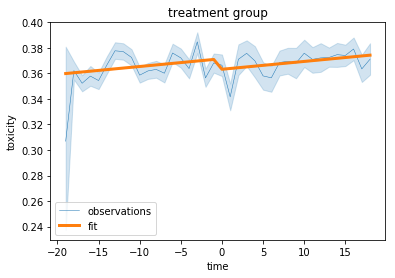

In [69]:
ax = sns.lineplot(data=data,x='time',y='toxicity',linewidth=0.5)
ax = sns.lineplot(data=data,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('toxicity');

# ITS for posting volume and removal rates

In [50]:
data = pd.read_csv("/mnt/storage/quarantine/data/theRedPillComments-toxicity.csv")

TrpRemovalCount = {}
TotalNumberComments = {}

for i, row in data.iterrows():
        body = row['body']
        postTime = row['created_utc']
        timeChunkIndex = getTimeChunkIndex(postTime)
        
        if timeChunkIndex in TotalNumberComments:
            TotalNumberComments[timeChunkIndex] += 1
        else:
            TotalNumberComments[timeChunkIndex] = 1
        
        ###count #removed
        if (body == "[removed]"):
            if timeChunkIndex in TrpRemovalCount:
                TrpRemovalCount[timeChunkIndex] += 1
            else:
                TrpRemovalCount[timeChunkIndex] = 1

##get the removal rate: i.e., #removed comments normalized by #total comments
TrpRemovalRate = {}
for k in TrpRemovalCount:
    if TotalNumberComments[k] == 0:
        TrpRemovalRate[k] = 0
    else:      
        TrpRemovalRate[k] = float(TrpRemovalCount[k])/(TotalNumberComments[k])

/nethome/eshwar3/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Optimization terminated successfully.
         Current function value: 327.718368
         Iterations 5
                            Results: Poisson
Model:                 Poisson            Pseudo R-squared:   0.561     
Dependent Variable:    counts             AIC:                24912.5960
Date:                  2019-07-11 18:16   BIC:                24917.5088
No. Observations:      38                 Log-Likelihood:     -12453.   
Df Model:              2                  LL-Null:            -28353.   
Df Residuals:          35                 LLR p-value:        0.0000    
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        5.0000                                           
------------------------------------------------------------------------
                        Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
Intercept               9.1077   0.0045 2045.259

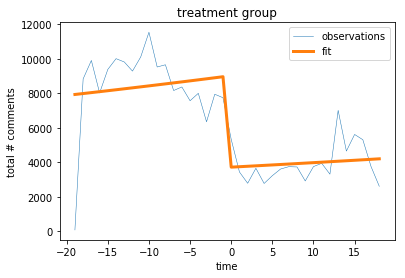

In [57]:
# posting volume
TotalNumberComments_df = pd.DataFrame()
TotalNumberComments_df['time'] = TotalNumberComments.keys()
TotalNumberComments_df['counts'] = TotalNumberComments.values()
TotalNumberComments_df['post_treatment'] = TotalNumberComments_df['time'] >= 0

# ITS
model = smf.poisson('counts ~ time + post_treatment',data = TotalNumberComments_df)
results = model.fit()

print(results.summary2())

# fitted values
TotalNumberComments_df['fit'] = np.exp(results.fittedvalues)
ax = sns.lineplot(data=TotalNumberComments_df,x='time',y='counts',linewidth=0.5)
ax = sns.lineplot(data=TotalNumberComments_df,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('total # comments');

Optimization terminated successfully.
         Current function value: 46.006044
         Iterations 5
                           Results: Poisson
Model:                 Poisson            Pseudo R-squared:   0.619    
Dependent Variable:    counts             AIC:                3502.4593
Date:                  2019-07-11 18:18   BIC:                3507.3721
No. Observations:      38                 Log-Likelihood:     -1748.2  
Df Model:              2                  LL-Null:            -4588.6  
Df Residuals:          35                 LLR p-value:        0.0000   
Converged:             1.0000             Scale:              1.0000   
No. Iterations:        5.0000                                          
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               7.0334   0.0128 550.5735 0.0000  7.00

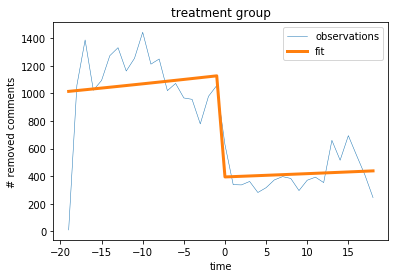

In [59]:
# # comments removed
TrpRemovalCount_df = pd.DataFrame()
TrpRemovalCount_df['time'] = TrpRemovalCount.keys()
TrpRemovalCount_df['counts'] = TrpRemovalCount.values()
TrpRemovalCount_df['post_treatment'] = TrpRemovalCount_df['time'] >= 0

# ITS
model = smf.poisson('counts ~ time + post_treatment',data = TrpRemovalCount_df)
results = model.fit()

print(results.summary2())

# fitted values
TrpRemovalCount_df['fit'] = np.exp(results.fittedvalues)
ax = sns.lineplot(data=TrpRemovalCount_df,x='time',y='counts',linewidth=0.5)
ax = sns.lineplot(data=TrpRemovalCount_df,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('# removed comments');

                   Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      0.695     
Dependent Variable:  counts            AIC:                 -262.2314 
Date:                2019-07-11 18:26  BIC:                 -257.3186 
No. Observations:    38                Log-Likelihood:      134.12    
Df Model:            2                 F-statistic:         43.07     
Df Residuals:        35                Prob (F-statistic):  3.67e-10  
R-squared:           0.711             Scale:               5.4661e-05
----------------------------------------------------------------------
                        Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
----------------------------------------------------------------------
Intercept               0.1257   0.0028 45.3825 0.0000  0.1201  0.1313
post_treatment[T.True] -0.0198   0.0048 -4.1224 0.0002 -0.0295 -0.0100
time                   -0.0001   0.0002 -0.5818 0.5644 -0.0006  0.0003
--------------------------

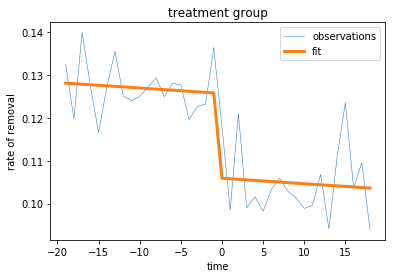

In [70]:
# # comments removed
TrpRemovalRate_df = pd.DataFrame()
TrpRemovalRate_df['time'] = TrpRemovalRate.keys()
TrpRemovalRate_df['counts'] = TrpRemovalRate.values()
TrpRemovalRate_df['post_treatment'] = TrpRemovalRate_df['time'] >= 0

# ITS
model = smf.ols('counts ~ time + post_treatment',data = TrpRemovalRate_df)
results = model.fit()

print(results.summary2())

# fitted values
TrpRemovalRate_df['fit'] = (results.fittedvalues)
# TrpRemovalRate_df['fit'] = np.exp(results.fittedvalues)
ax = sns.lineplot(data=TrpRemovalRate_df,x='time',y='counts',linewidth=0.5)
ax = sns.lineplot(data=TrpRemovalRate_df,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('rate of removal');

# Influx of new users

In [71]:
RED_PILL_COMMENTS_FILE = "/mnt/storage/quarantine/data/theRedPillComments.csv"
authorsInEachChunk = defaultdict(set)

with open(RED_PILL_COMMENTS_FILE) as csvfile:
    readCSV = csv.DictReader(csvfile)
    for row in readCSV:
        author = row['author']
        if (author != "[deleted]"):
            postTime = row['created_utc']
            timeChunkIndex = getTimeChunkIndex(postTime)
            authorsInEachChunk[timeChunkIndex].add(author)            

In [72]:
lists = sorted(authorsInEachChunk.items())

In [73]:
seenUsersSet = set()
for ulist in lists[0:3]:
    chunkUsers = ulist[1]
    seenUsersSet = seenUsersSet.union(chunkUsers)

In [74]:
newsUsersCount = defaultdict(int)
for ulist in lists[4:]:
    chunkIndex = ulist[0]
    chunkUsers = ulist[1]
    newUsersSet = chunkUsers.difference(seenUsersSet)
    newsUsersCount[chunkIndex] = len(newUsersSet)
    seenUsersSet = seenUsersSet.union(chunkUsers)

Optimization terminated successfully.
         Current function value: 13.015632
         Iterations 6
                           Results: Poisson
Model:                  Poisson            Pseudo R-squared:   0.897   
Dependent Variable:     counts             AIC:                891.0630
Date:                   2019-07-17 02:37   BIC:                895.6421
No. Observations:       34                 Log-Likelihood:     -442.53 
Df Model:               2                  LL-Null:            -4300.7 
Df Residuals:           31                 LLR p-value:        0.0000  
Converged:              1.0000             Scale:              1.0000  
No. Iterations:         6.0000                                         
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               6.4317   0.0169 381.3914 0.0000  6.39

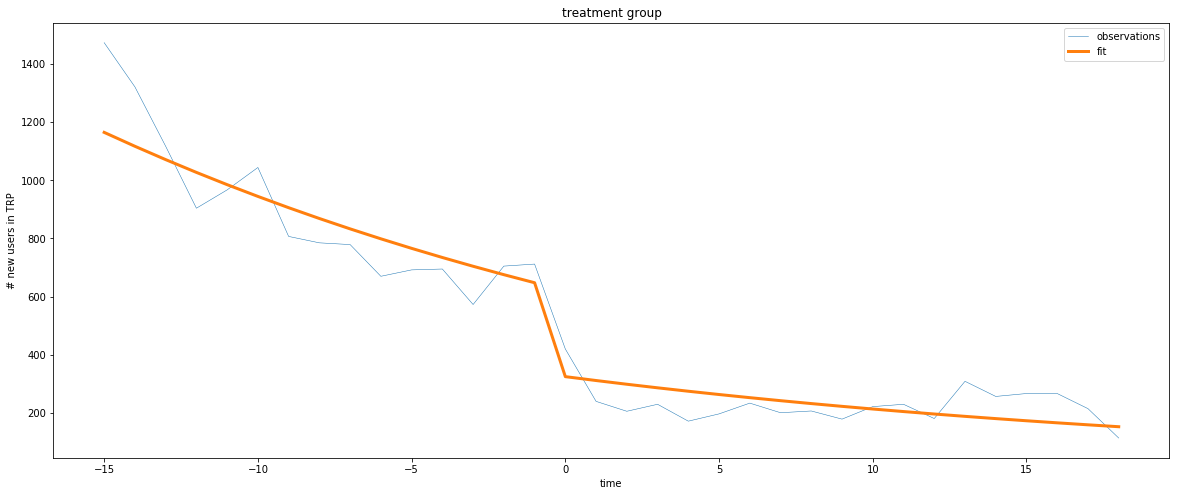

In [76]:
# # comments removed
TrpNewUsersCount_df = pd.DataFrame()
TrpNewUsersCount_df['time'] = newsUsersCount.keys()
TrpNewUsersCount_df['counts'] = newsUsersCount.values()
TrpNewUsersCount_df['post_treatment'] = TrpNewUsersCount_df['time'] >= 0

# ITS
model = smf.poisson('counts ~ time + post_treatment',data = TrpNewUsersCount_df)
results = model.fit()

print(results.summary2())

# fitted values
TrpNewUsersCount_df['fit'] = np.exp(results.fittedvalues)
ax = sns.lineplot(data=TrpNewUsersCount_df,x='time',y='counts',linewidth=0.5)
ax = sns.lineplot(data=TrpNewUsersCount_df,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('# new users in TRP');

### The treatment reduced the number of newcomers on TRP by e^-0.6478 = 48%